In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model as skl
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial 

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
             (Stepwise,
              sklearn_selected,
               sklearn_selection_path)
!pip install l0bnb
from l0bnb import fit_path

Defaulting to user installation because normal site-packages is not writeable


### Subset Selection Methods

#### Forward Selection 

In [5]:
Hitters=load_data ('Hitters')
np.isnan(Hitters['Salary']).sum()

59

In [6]:
Hitters=Hitters.dropna();
Hitters.shape

(263, 20)

In [7]:
def nCp(sigma2,estimator,X,Y):
    "Negative Cp statistic"
    n,p=X.shape
    Yhat=estimator.predict(X)
    RSS=np.sum((Y-Yhat)**2)
    return-(RSS+2*p*sigma2)/n

In [8]:
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)
Y=np.array(Hitters['Salary'])
X=design.transform(Hitters)
sigma2=OLS(Y,X).fit().scale

In [9]:
neg_Cp=partial(nCp,sigma2)

In [10]:
strategy=Stepwise.first_peak(design ,direction='forward',max_terms=len(design.terms))

In [11]:
hitters_MSE=sklearn_selected(OLS,strategy)
hitters_MSE.fit(Hitters,Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [12]:
hitters_Cp=sklearn_selected(OLS,
                            strategy,
                            scoring=neg_Cp)
hitters_Cp.fit(Hitters,Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

#### Choosing Among Models Using The Validation Set Approach and Cross Validation

In [14]:
strategy=Stepwise.fixed_steps(design,len(design.terms),
                              direction='forward')
full_path=sklearn_selection_path(OLS,strategy)

In [15]:
full_path.fit(Hitters,Y)
Yhat_in =full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

(50000.0, 250000.0)

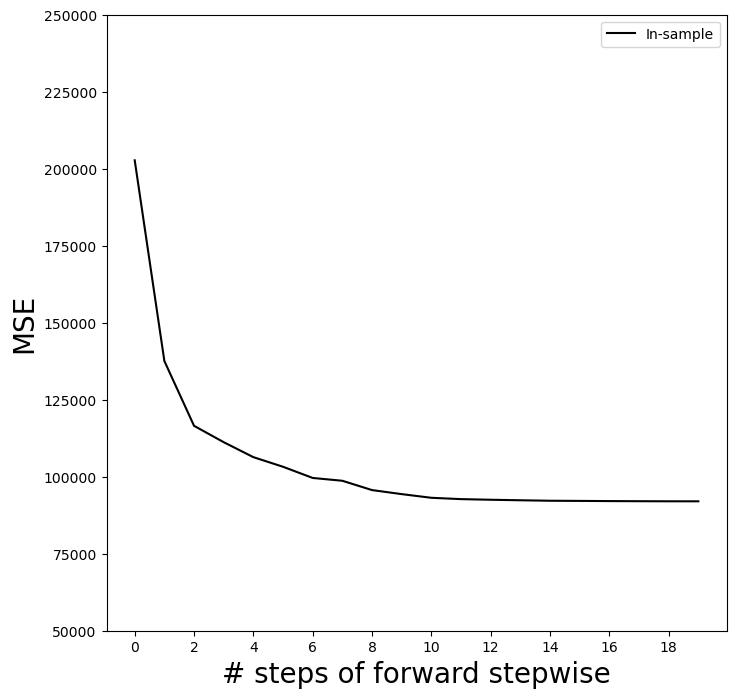

In [16]:
 mse_fig, ax = subplots(figsize=(8,8))
 insample_mse = ((Yhat_in- Y[:,None])**2).mean(0)
 n_steps = insample_mse.shape[0]
 ax.plot(np.arange(n_steps),
 insample_mse,
 'k', # color black
 label='In-sample')
 ax.set_ylabel('MSE',
 fontsize=20)
 ax.set_xlabel('# steps of forward stepwise',
 fontsize=20)
 ax.set_xticks(np.arange(n_steps)[::2])
 ax.legend()
ax.set_ylim([50000,250000])

In [17]:
K=5
kfold=skm.KFold(K,
                random_state=0,
                shuffle=True)
Yhat_cv=skm.cross_val_predict(full_path,
                              Hitters,
                              Y,cv=kfold)
Yhat_cv.shape

(263, 20)

In [18]:
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
     errors = (Yhat_cv[test_idx]- Y[test_idx,None])**2
     cv_mse.append(errors.mean(0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

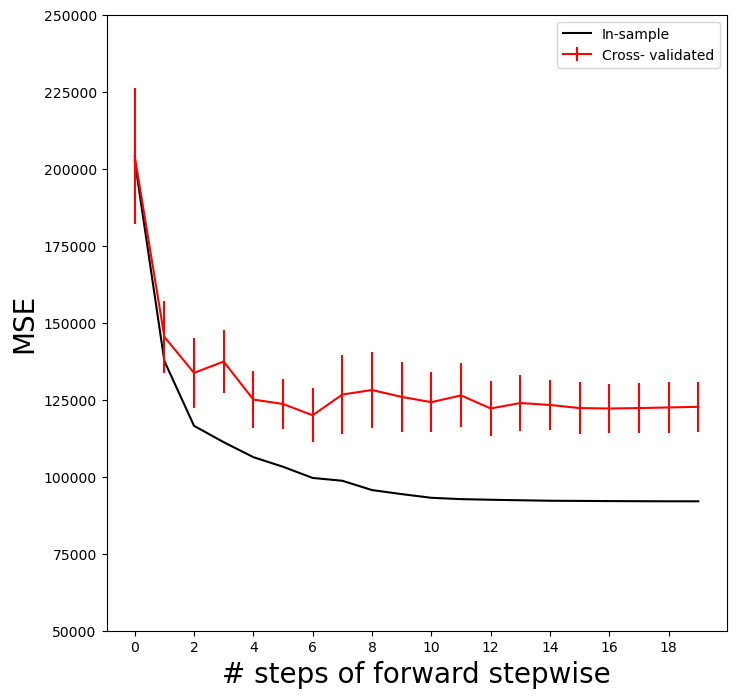

In [19]:
ax.errorbar(np.arange(n_steps),
            cv_mse.mean(1),
            cv_mse.std(1)/np.sqrt(K),
            label='Cross- validated',
            c='r')# color red
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

In [20]:
validation = skm.ShuffleSplit(n_splits=1,
test_size=0.2,
random_state=0)
for train_idx, test_idx in validation.split(Y):
     full_path.fit(Hitters.iloc[train_idx],
                   Y[train_idx])
     Yhat_val = full_path.predict(Hitters.iloc[test_idx])
     errors = (Yhat_val- Y[test_idx,None])**2
     validation_mse = errors.mean(0)

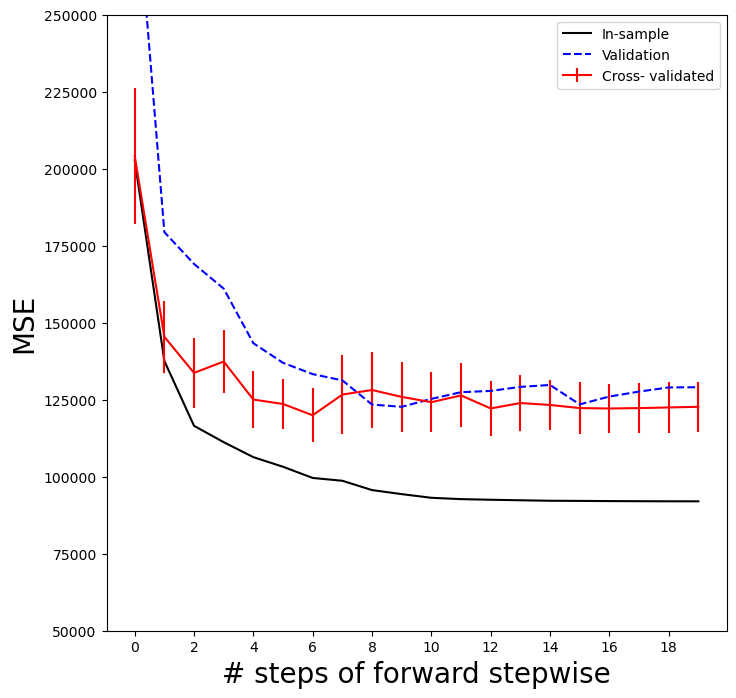

In [21]:
 ax.plot(np.arange(n_steps),
 validation_mse,
 'b--', # color blue, broken line
 label='Validation')
 ax.set_xticks(np.arange(n_steps)[::2])
 ax.set_ylim([50000,250000])
 ax.legend()
 mse_fig

#### Best Subset Selection

In [23]:
D=design.fit_transform(Hitters)
D=D.drop('intercept',axis=1)
X=np.asarray(D)

In [24]:
path=fit_path(X,
              Y,
              max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


In [25]:
path[3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555505,
 'lambda_0': 0.01141624802745019,
 'M': 0.5829861733382014,
 'Time_exceeded': False}

### Rigde Regression and the Lasso

In [53]:
# ✅ First: make sure this import works (after upgrading sklearn)
from sklearn.linear_model import elastic_net_path
import numpy as np

# ✅ Standardize X
Xs = X - X.mean(0)
X_scale = X.std(0)
Xs = Xs / X_scale

# ✅ Create lambda path
lambdas = 10**np.linspace(8, -2, 100) / Y.std()

# ✅ Compute path (Ridge: l1_ratio=0)
_, soln_array, _ = elastic_net_path(Xs, Y, l1_ratio=0., alphas=lambdas)

# ✅ Check shape of solution array
print(soln_array.shape)


ImportError: cannot import name 'elastic_net_path' from 'sklearn.linear_model' (C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\__init__.py)

In [55]:
soln_path =pd.DataFrame(soln_array.T,
                        columns=D.columns,
                        index=-np.log(lambdas))
soln_path.index.name='negative log(lambda)'
soln_path

NameError: name 'soln_array' is not defined

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
C:\Users\acer\AppData\Local\Temp\ipykernel_39344\1565222265.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
C:\Users\acer\AppData\Local\Temp\ipykernel_39344\1565222265.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\lambda)$', fontsize=20)


NameError: name 'soln_path' is not defined

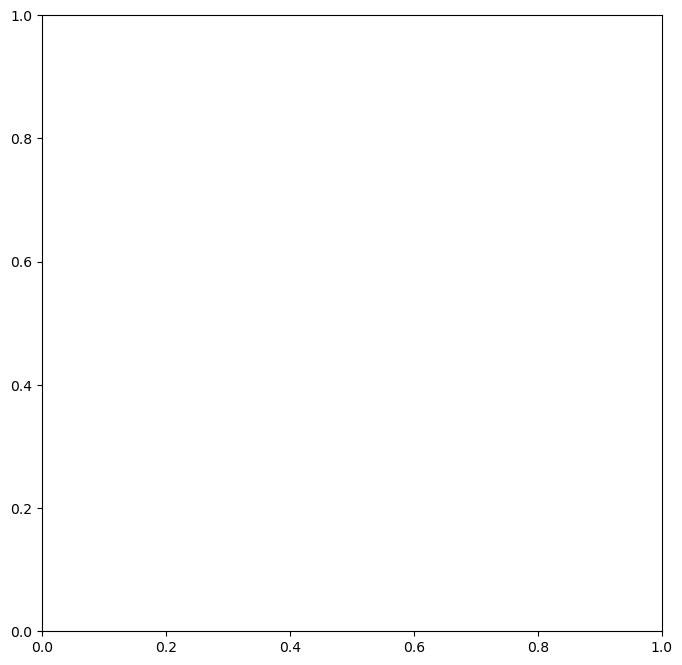

In [39]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

In [41]:

beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

NameError: name 'soln_path' is not defined

In [43]:
 np.linalg.norm(beta_hat)

NameError: name 'beta_hat' is not defined

In [ ]:
 beta_hat = soln_path.loc[soln_path.index[59]]
 lambdas[59], np.linalg.norm(beta_hat)

In [ ]:
 ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
 scaler = StandardScaler(with_mean=True, with_std=True)
 pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
 pipe.fit(X, Y)

In [134]:
 np.linalg.norm(ridge.coef_)

160.42371017725918

#### Estimating Test Error Of Ridge Regression

In [140]:
 validation = skm.ShuffleSplit(n_splits=1,
 test_size=0.5,
 random_state=0)
 ridge.alpha = 0.01
 results = skm.cross_validate(ridge,
 X,
 Y,
 scoring='neg_mean_squared_error',
 cv=validation)
-results['test_score']

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([134214.00419204])

In [148]:
 ridge.alpha = 1e10
 results = skm.cross_validate(ridge,
 X,
 Y,
 scoring='neg_mean_squared_error',
 cv=validation)
-results['test_score']

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([231788.32155285])

In [150]:
 param_grid = {'ridge__alpha': lambdas}
 grid = skm.GridSearchCV(pipe,
 param_grid,
 cv=validation,
 scoring='neg_mean_squared_error')
 grid.fit(X, Y)
 grid.best_params_['ridge__alpha']
 grid.best_estimator_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

In [152]:
 grid = skm.GridSearchCV(pipe,
                    param_grid,
                    cv=kfold,
                    scoring='neg_mean_squared_error')
 grid.fit(X, Y)
 grid.best_params_['ridge__alpha']
 grid.best_estimator_

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linea

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])